In [1]:
import unicodedata
import string
import re
import time
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import pickle

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 导入数据

- 导入数据
- 并将数据保存为pkl的格式

In [2]:
def convert_to_pickle(item, directory):
    """导出数据
    """
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    """导入数据
    """
    return pickle.load(open(directory,"rb"))

In [5]:
data = pd.read_csv('./data/train.csv',lineterminator='\n',encoding='utf-8')

In [5]:
data.head()

,ID,review,label
0,1,Jo bhi ap se tou behtar hoon,Negative
1,2,ya Allah meri sister Affia ki madad farma,Positive
2,3,Yeh khud chahta a is umar main shadi krna. ha...,Negative
3,4,Tc ? Apky mun xe exe alfax achy nae lgty 😒💃,Negative
4,5,Good,Positive


## 数据的预处理

数据预处理大致分为下面几个部分.

1. 将所有字母转为Ascii
2. 将大写都转换为小写; 同时, 只保留常用的标点符号
3. 新建完成, word2idx, idx2word, word2count(每个单词出现的次数), n_word(总的单词个数)
4. 将句子转换为Tensor, 每个word使用index来进行代替
5. 对句子进行填充, 使每句句子的长度相同, 这样可以使用batch进行训练
6. 将label转换为one-hot的格式, 方便最后的训练(Pytorch中只需要转换为标号即可)

### 创建word2index和index2word

In [3]:
# 第一步数据预处理
def unicodeToAscii(s):
    """转换为Ascii
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 第二步数据预处理
def normalizeString(s):
    """转换为小写, 同时去掉奇怪的符号
    """
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# 第三步数据预处理
class Lang():
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        # 初始的时候SOS表示句子开头(0还在padding的时候会进行填充), EOS表示句子结尾(或是表示没有加入index中的新的单词, 即不常用的单词)
        self.index2word = {0:"SOS",1:"EOS"}
        self.n_words = 2
    
    def addSentence(self, sentence):
        """把句子中的每个单词加入字典中
        """
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words # 新单词的标号
            self.word2count[word] = 1 # 新单词的个数
            self.index2word[self.n_words] = word
            self.n_words = self.n_words + 1
        else:
            self.word2count[word] = self.word2count[word] + 1

In [6]:
# 把数据集中的每句话中的单词进行转化
lang = Lang()
for sentence_data in data["review"].values.tolist():
    # 数据清洗
    sentence_data = normalizeString(sentence_data)
    # 增加word2index
    lang.addSentence(sentence_data)

# 显示一些统计数据
print("Count word:{}".format(lang.n_words))

Count word:17684


In [7]:
# 打印一下单词个数的分布
data_count = np.array(list(lang.word2count.values()))

# 有大量单词只出现了很少的次数
np.median(data_count), np.mean(data_count), np.max(data_count) 

(1.0, 5.799343965614749, 3033)

In [8]:
# 计算<n的单词, 出现次数占总的出现次数的比例
less_count = 0
total_count = 0

for _,count in lang.word2count.items():
    if count < 2:
        less_count = less_count + count
    total_count = total_count + count

print("小于N的单词出现次数 : ",less_count,
      "\n总的单词出现次数 : ",total_count,
      "\n小于N的单词占比 : ",less_count/total_count*100)

小于N的单词出现次数 :  10547 
总的单词出现次数 :  102544 
小于N的单词占比 :  10.285340926821657


In [9]:
# 我们设置单词至少出现2次
lang_process = Lang()

for word,count in lang.word2count.items():
    if count >= 2:
        lang_process.word2index[word] = lang_process.n_words # 新单词的标号
        lang_process.word2count[word] = count # 新单词的个数
        lang_process.index2word[lang_process.n_words] = word
        lang_process.n_words = lang_process.n_words + 1
        
# 显示一些统计数据
print("Count word:{}".format(lang_process.n_words))

Count word:7137


In [10]:
# 简单查看一下lang_process留下的单词
lang_process.word2count

{'jo': 319,
 'bhi': 670,
 'ap': 276,
 'se': 1235,
 'tou': 99,
 'behtar': 43,
 'hoon': 44,
 'ya': 182,
 'allah': 508,
 'meri': 129,
 'sister': 4,
 'ki': 2298,
 'madad': 39,
 'farma': 31,
 'yeh': 231,
 'khud': 96,
 'chahta': 11,
 'a': 90,
 'is': 597,
 'umar': 38,
 'main': 335,
 'shadi': 63,
 'krna': 38,
 '.': 3033,
 'had': 26,
 'tc': 2,
 '?': 349,
 'apky': 6,
 'mun': 6,
 'xe': 3,
 'exe': 2,
 'achy': 15,
 'nae': 48,
 'lgty': 3,
 '': 642,
 'good': 110,
 'american': 12,
 'president': 8,
 'john': 2,
 'f': 6,
 'kennedy': 2,
 'aur': 1264,
 'in': 368,
 'ke': 2002,
 'bhai': 124,
 'marilyn': 8,
 'monroe': 5,
 'ka': 1380,
 'charcha': 3,
 'raha': 138,
 'commission': 6,
 'dor': 27,
 'dora': 4,
 'quomi': 5,
 'farokhat': 2,
 'keye': 11,
 'gaye': 96,
 'pak': 138,
 'nazer': 6,
 'e': 427,
 'bd': 3,
 'sy': 129,
 'bechye': 2,
 'or': 420,
 'humesha': 2,
 'bohat': 177,
 'dy': 67,
 'ameeen': 3,
 'amoman': 2,
 'log': 95,
 'samajhte': 5,
 'hain': 608,
 'jhok': 2,
 'hi': 330,
 'abid': 8,
 'ali': 82,
 'pheli': 13

In [11]:
convert_to_pickle(lang_process, './data/lang_process.pkl')

### 将text转换为Tensor

- 将text转换为Tensor(转换之前, 需要先要将单词进行标准化)

In [11]:
# 把data中的句子按顺序转为tensor
# 这里转换的时候,句子中的单词也是需要标准化的
def convertWord2index(word):
    if lang_process.word2index.get(word)==None:
        # 一些出现次数很少的词汇使用1来表示
        return 1
    else:
        return lang_process.word2index.get(word)
    
input_tensor = [[convertWord2index(s) for s in normalizeString(es).split(' ')]  for es in data["review"].values.tolist()]

In [12]:
# 查看最后两句话
input_tensor[-2:]

[[192, 288, 1741, 239, 2065, 1552, 1, 4867, 169, 487, 5937, 181, 1552, 28],
 [5012,
  1,
  1,
  3569,
  5,
  2386,
  7113,
  43,
  1,
  145,
  1,
  406,
  49,
  6395,
  4930,
  753,
  1923,
  84]]

In [13]:
data["review"].values.tolist()[-2:]

['Ma na suna ha lemon sa haddiyan kamzor hoti hn regular Lana sa?',
 'Ball poar jadooi giraft se inhe rafter aur swing ko qaboo karne ka hairat angez fun aata hai']

In [17]:
# 这个index可以和word对应上(可以看到是忽略大小写的-这个很重要)
lang_process.index2word[192]

'ma'

### Word Padding

- 将Tensor转换为定长的Tensor, 多余的去掉, 不足的补0

In [14]:
# 查看句子的平均长度, 长度的中位数, 最长的长度
sentence_length = [len(t) for t in input_tensor]
print(np.mean(sentence_length))
print(np.median(sentence_length))
print(np.max(sentence_length))

16.20480404551201
12.0
313


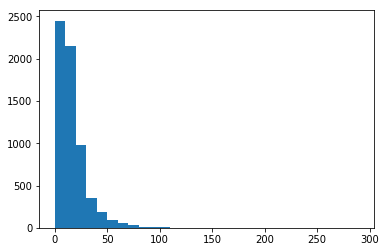

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bins = np.arange(0,300,10) # 产生区间刻度

ax.hist(sentence_length,bins=bins)
fig.show()

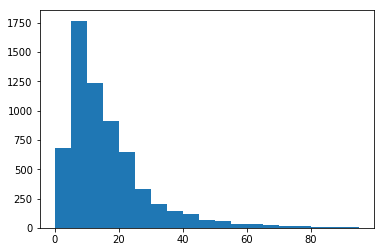

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bins = np.arange(0,100,5) # 产生区间刻度

ax.hist(sentence_length,bins=bins)
fig.show()

根据上面的图像, 我们可以知道, 句子长度取80是一个比较好的值.

即超过80个单词的句子去掉后面的部分, 少于80个单词的句子后面补充0.

In [15]:
def pad_sequences(x, max_len):
    """定义自动填充的函数
    """
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: 
        padded[:] = x[:max_len]
    else: 
        padded[:len(x)] = x
    return padded

In [16]:
input_tensor = [pad_sequences(x, 80) for x in input_tensor]

In [17]:
# 查看一下完成填充之后的数据
input_tensor[-2:]

[array([ 192,  288, 1741,  239, 2065, 1552,    1, 4867,  169,  487, 5937,
         181, 1552,   28,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0], dtype=int64),
 array([5012,    1,    1, 3569,    5, 2386, 7113,   43,    1,  145,    1,
         406,   49, 6395, 4930,  753, 1923,   84,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    

### 将Label(转换为one-hot的格式)

In [18]:
# 查看一下所有的分类
data['label'].unique()

array(['Negative', 'Positive'], dtype=object)

In [19]:
index2emotion = {0: 'Negative', 1: 'Positive'}
emotion2index = {'Negative' : 0, 'Positive' : 1}
target_tensor = [emotion2index.get(s) for s in data['label'].values.tolist()]

In [20]:
# 简单查看一下样本
target_tensor[:10]

[0, 1, 0, 0, 1, 0, 0, 1, 1, 0]

In [19]:
convert_to_pickle(input_tensor, './data/input_tensor.pkl')
convert_to_pickle(target_tensor, './data/target_tensor.pkl')

到这里，数据集的预处理就已经全部处理好了，下面就是创建Data Loader, 最后可以用来放入整个模型中去.

## Data Loader

- 数据集的划分, 训练集和测试集
- 数据集的加载, 使用DataLoader来加载数据集

In [21]:
# 数据集的划分(这里全部是训练集)
END = int(len(input_tensor)*0.9)

# 将数据转为tensor的数据格式
input_tensor_train = torch.from_numpy(np.array(input_tensor[:END]))
target_tensor_train = torch.from_numpy(np.array(target_tensor[:END])).long()

input_tensor_test = torch.from_numpy(np.array(input_tensor[END:]))
target_tensor_test = torch.from_numpy(np.array(target_tensor[END:])).long()

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_test), len(target_tensor_test)

(5695, 5695, 633, 633)

In [3]:
test_loader = load_from_pickle('./data/test_loader.pkl')

In [5]:
for i,j in test_loader:
    print(i.shape,j.shape)

torch.Size([64, 80]) torch.Size([64])
torch.Size([64, 80]) torch.Size([64])
torch.Size([64, 80]) torch.Size([64])
torch.Size([64, 80]) torch.Size([64])
torch.Size([64, 80]) torch.Size([64])
torch.Size([64, 80]) torch.Size([64])
torch.Size([64, 80]) torch.Size([64])
torch.Size([64, 80]) torch.Size([64])
torch.Size([64, 80]) torch.Size([64])
torch.Size([57, 80]) torch.Size([57])


In [23]:
# 加载dataloader
train_dataset = Data.TensorDataset(input_tensor_train, target_tensor_train) # 训练样本
test_dataset = Data.TensorDataset(input_tensor_test, target_tensor_test) # 测试样本

MINIBATCH_SIZE = 64

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2           # set multi-work num read data
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2           # set multi-work num read data
)

In [24]:
convert_to_pickle(train_loader, './data/train_loader.pkl')
convert_to_pickle(test_loader, './data/test_loader.pkl')

到这里，就创建好了dataload, 后面就可以开始构建网络，可以开始训练了

## 创建Model

### 创建GRU模型

In [25]:
# GRU的model
class EmotionGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size, layers=2):
        super(EmotionGRU, self).__init__()
        self.vocab_size = vocab_size # 总的单词的个数
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.batch_sz = batch_sz
        self.output_size = output_size
        self.num_layers = layers
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim) # 可以将标号转为向量
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units, num_layers=self.num_layers, batch_first = True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(self.hidden_units*2, self.output_size)
        
    def init_hidden(self):
        # 使用了双向RNN, 所以num_layer*2
        return torch.zeros((self.num_layers*2, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self,x):
        self.batch_sz = x.size(0)
        # print(x.shape)
        x = self.embedding(x)
        # print(x.shape)
        self.hidden = self.init_hidden()
        output, self.hidden = self.gru(x, self.hidden)
        # print(output.shape)
        # 因为是 batch*seq*output, 所以要取最后一个seq
        output = output[:,-1,:]
        output = self.dropout(output)
        output = self.fc(output)
        # print(output.shape)
        return output

In [26]:
# 测试模型
vocab_inp_size = len(lang_process.word2index)
embedding_dim = 256
hidden_units = 512
target_size = 2 # 一共有2种emotion
layers = 3

# 测试模型
model = EmotionGRU(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)

# 测试数据
it = iter(train_loader)
x, y = next(it)

output = model(x.to(device))

In [27]:
# 64*2, 表示一共有64个样本, 每个样本是2个emotion的概率
output.size()

torch.Size([64, 2])

In [28]:
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (logit == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [29]:
accuracy(output,y.to(device))

tensor(50, device='cuda:0')

### 创建LSTM模型

In [32]:
# LSTM的model
class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size, layers=2):
        super(EmotionLSTM, self).__init__()
        self.vocab_size = vocab_size # 总的单词的个数
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.batch_sz = batch_sz
        self.output_size = output_size
        self.num_layers = layers
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim) # 可以将标号转为向量
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.LSTM(self.embedding_dim, self.hidden_units, num_layers=self.num_layers, batch_first = True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(self.hidden_units*2, self.output_size)

    def init_hidden(self):
        # 使用了双向RNN, 所以num_layer*2
        return (torch.zeros((self.num_layers*2, self.batch_sz, self.hidden_units)).to(device),
               torch.zeros((self.num_layers*2, self.batch_sz, self.hidden_units)).to(device))
    
    def forward(self,x):
        self.batch_sz = x.size(0)
        # print(x.shape)
        x = self.embedding(x)
        # print(x.shape)
        (self.hidden, self.cell_state) = self.init_hidden()
        output, (self.hidden, self.cell_state) = self.gru(x, (self.hidden, self.cell_state))
        # print(output.shape)
        # 因为是 batch*seq*output, 所以要取最后一个seq
        output = output[:,-1,:]
        output = self.dropout(output)
        output = self.fc(output)
        # print(output.shape)
        return output

In [33]:
# 测试模型
vocab_inp_size = len(lang_process.word2index)
embedding_dim = 256
hidden_units = 512
target_size = 2 # 一共有2种emotion
layers = 3

# 测试模型
model = EmotionLSTM(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)

# 测试数据
it = iter(train_loader)
x, y = next(it)

output = model(x.to(device))

In [34]:
output.shape

torch.Size([64, 2])

## 训练模型
- 定义损失函数
- 定义优化器

- 开始训练

In [36]:
# 模型超参数
vocab_inp_size = len(lang_process.word2index)
embedding_dim = 256
hidden_units = 512
target_size = 2 # 一共有6种emotion
num_layers = [1,2,3]

for layers in num_layers:
    # 测试模型
    modelGRU = EmotionGRU(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)
    modelLSTM = EmotionLSTM(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)
    models = {'GRU':modelGRU, 'LSTM',modelLSTM}
    for key, model in models.items():
        # 定义损失函数和优化器
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(),lr=0.001)

        # 开始训练
        num_epochs = 25
        for epoch in range(num_epochs):
            start = time.time()

            train_total_loss = 0 # 记录一整个epoch中的平均loss
            train_total_accuracy = 0 # 记录一整个epoch中的平均accuracy

            ### Training
            for batch, (inp, targ) in enumerate(train_loader):
                predictions = model(inp.to(device))  
                # 计算误差     
                loss = criterion(predictions, targ.to(device))
                # 反向传播, 修改weight
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 记录Loss下降和准确率的提升
                ba   tch_loss = (loss / int(targ.size(0))) # 记录一个bacth的loss      
                batch_accuracy = accuracy(predictions, targ.to(device))

                train_total_loss = train_total_loss + batch_loss
                train_total_accuracy = train_total_accuracy + batch_accuracy

                if batch % 25 == 0:
                    record_train_accuracy = train_total_accuracy.cpu().detach().numpy()/(batch+1)
                    print('Epoch {} Batch {} Accuracy {:.4f}. Loss {:.4f}'.format(epoch + 1,
                                                                 batch,
                                                                 train_total_accuracy.cpu().detach().numpy()/(batch+1),
                                                                 train_total_loss.cpu().detach().numpy()/(batch+1)))
            # 每一个epoch来计算在test上的准确率
            print('------------')
            model.eval()
            test_total_accuracy = 0
            for batch, (input_data, target_data) in enumerate(test_loader):
                predictions = model(input_data.to(device))
                batch_accuracy = accuracy(predictions, target_data.to(device))
                test_total_accuracy = test_total_accuracy + batch_accuracy
            print('Test : Lay {}, Model {}, Epoch {} Accuracy {:.4f}'.format(layers, key, epoch + 1, test_total_accuracy.cpu().detach().numpy()/(batch+1)))
            record_test_accuracy = test_total_accuracy.cpu().detach().numpy()/(batch+1)

            if epoch == num_epochs - 1:
                # 把最后一轮的结果写入文件
                with open('byr.txt','a') as file:
                    file.write('{},{},{:.4f},{:.4f}'.format(key,layers,record_train_accuracy,record_test_accuracy))
            print('============')

Epoch 1 Batch 0 Accuracy 51.0000. Loss 0.0109
Epoch 1 Batch 25 Accuracy 50.0000. Loss 0.0130
Epoch 1 Batch 50 Accuracy 49.1569. Loss 0.0121
Epoch 1 Batch 75 Accuracy 49.7237. Loss 0.0117
Epoch 2 Batch 0 Accuracy 64.0000. Loss 0.0101
Epoch 2 Batch 25 Accuracy 52.5000. Loss 0.0110
Epoch 2 Batch 50 Accuracy 54.1569. Loss 0.0108
Epoch 2 Batch 75 Accuracy 58.1842. Loss 0.0104
Epoch 3 Batch 0 Accuracy 75.0000. Loss 0.0073
Epoch 3 Batch 25 Accuracy 73.3462. Loss 0.0085
Epoch 3 Batch 50 Accuracy 73.8431. Loss 0.0084
Epoch 3 Batch 75 Accuracy 73.6579. Loss 0.0083
Epoch 4 Batch 0 Accuracy 84.0000. Loss 0.0057
Epoch 4 Batch 25 Accuracy 85.1154. Loss 0.0056
Epoch 4 Batch 50 Accuracy 84.6078. Loss 0.0056
Epoch 4 Batch 75 Accuracy 84.4211. Loss 0.0056
Epoch 5 Batch 0 Accuracy 82.0000. Loss 0.0057
Epoch 5 Batch 25 Accuracy 91.6538. Loss 0.0033
Epoch 5 Batch 50 Accuracy 91.0784. Loss 0.0034
Epoch 5 Batch 75 Accuracy 91.0000. Loss 0.0034
Epoch 6 Batch 0 Accuracy 90.0000. Loss 0.0025
Epoch 6 Batch 25 Ac

In [68]:
# 保存模型
torch.save(model, 'EmotionRNN.pkl')

### 二分类问题计算AUC

In [67]:
import numpy as np
from sklearn import metrics

In [75]:
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)

0.75

## 预测新的数据集

In [37]:
data_test = pd.read_csv('./data/20190610_test.csv',lineterminator='\n',encoding='utf-8')

In [20]:
data_test = load_from_pickle('./data/20190610_test.pkl')

In [21]:
data_test.head()

,ID,review
0,1,Sarcasm acha karti ho xD
1,2,Ali tareen ki kon c study yar...... ye bhai ph...
2,3,Sharab Juwa Butt Aur Faal K Teer Shaitani Kam ...
3,4,salam hakeem sahab mne pore ramadan boht faida...
4,5,Bata ku nae dyty ake dusray ko apny dil ki baat


In [39]:
# 将数据存为pkl格式, 方便之后的使用
convert_to_pickle(data_test, './data/20190610_test.pkl')

### 测试数据转换

- 将测试数据转换为向量(文本向量话)
- 将测试数据进行padding
- 将测试数据转换为tenor(转换为可以放在Pytorch中进行训练的变量)

In [22]:
# 转换为tensor
test_tensor = [[convertWord2index(s) for s in normalizeString(es).split(' ')]  for es in data_test["review"].values.tolist()]

In [23]:
test_tensor[:2]

[[1, 327, 189, 101, 3270],
 [77,
  1595,
  13,
  2568,
  640,
  1,
  127,
  25,
  25,
  25,
  25,
  25,
  25,
  83,
  46,
  1435,
  1848,
  1,
  1,
  73,
  25,
  25,
  25,
  25,
  83,
  101,
  1442,
  114,
  25,
  25,
  25,
  25,
  25,
  1206,
  1,
  125,
  6158,
  5232,
  101,
  25,
  25,
  25,
  4452,
  1,
  96,
  710,
  25,
  25,
  25,
  1,
  1,
  202,
  25,
  25,
  25,
  4557,
  141,
  5218,
  101,
  28,
  28,
  28]]

In [24]:
# 这个index可以和word对应上(可以看到是忽略大小写的-这个很重要)
lang_process.index2word[77], lang_process.index2word[3270]

('ali', 'xd')

In [25]:
# 数据进行padding
test_tensor = [pad_sequences(x, 80) for x in test_tensor]

In [26]:
test_tensor[:2]

[array([   1,  327,  189,  101, 3270,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0], dtype=int64),
 array([  77, 1595,   13, 2568,  640,    1,  127,   25,   25,   25,   25,
          25,   25,   83,   46, 1435, 1848,    1,    1,   73,   25,   25,
          25,   25,   83,  101, 1442,  114,   25,   25,   25,   25,   25,
        1206,    1,  125, 6158, 5232,  101,   25,   25,   25, 4452,    1,
          96,  710,   25,   25,   25,    1,    1,  202,   25,   25,   25,
        4557,  141, 5218,  101,   28,   28,   28,    0,    0,    0,    

In [27]:
# 把模型保存了
convert_to_pickle(test_tensor, './data/test_tensor.pkl')

In [30]:
# 将数据转为tensor的数据格式
input_tensor_test = torch.from_numpy(np.array(test_tensor))

In [53]:
len(input_tensor_test)

2712

In [31]:
MINIBATCH_SIZE = 64

test_loader = Data.DataLoader(
    dataset=input_tensor_test,
    batch_size=MINIBATCH_SIZE,
    shuffle=False,
    num_workers=1          # set multi-work num read data
)

### 进行预测

- 模型的测试
- test的测试结果输出

In [32]:
# 加载模型
model = torch.load('EmotionRNN.pkl')

In [33]:
# 测试数据
it = iter(test_loader)
x = next(it)

model.eval()
output = model(x.to(device))

In [34]:
output.shape

torch.Size([64, 2])

In [44]:
output[:2]

tensor([[-5.6093,  4.5610],
        [ 5.9950, -4.9071]], device='cuda:0', grad_fn=<SliceBackward>)

In [45]:
F.softmax(output[:2],dim=1)

tensor([[3.8287e-05, 9.9996e-01],
        [9.9998e-01, 1.8417e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [51]:
F.softmax(output[:2],dim=1).cpu().detach().numpy()

array([[3.8287195e-05, 9.9996173e-01],
       [9.9998164e-01, 1.8417459e-05]], dtype=float32)

In [52]:
# fmt='%f'控制保存为小数
np.savetxt("test.csv", F.softmax(output[:2],dim=1).cpu().detach().numpy(), delimiter=",", fmt='%f')

In [37]:
# 确保输出的顺序是和之前的顺序是一样的
x[:2]

tensor([[   1,  327,  189,  101, 3270,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  77, 1595,   13, 2568,  640,    1,  127,   25,   25,   25,   25,   25,
           25,   83,   46, 1435, 1848,    1,    1,   73,   25,   25,   25,   25,
           83,  101, 1442,  114,   25,   25,   25,   25,   25, 1206,    1,  125,
         6158, 5232,  101,   25,   25,   25, 4452,    1,   96,  710,   25,   25,
           25,    1,    1,  202,   25,   25,   25, 4557,  141, 5218,  101,   28,
           28,   28,    0,    0,    0,    0,    0, 

In [56]:
output_results = np.zeros((len(input_tensor_test),2))
output_results.shape

(2712, 2)

In [57]:
output_results[0:64].shape

(64, 2)

In [71]:
# 所有数据的预测
model.eval()

output_results = np.zeros((len(input_tensor_test),2))

with torch.no_grad():
    start = 0
    end = 0
    for batch, input_data in enumerate(test_loader):
        input_data = input_data.to(device)
        outputs = model(input_data)
        outputs = F.softmax(outputs,dim=1)
        SIZE = outputs.size(0)
        start = end
        end = end + SIZE
        output_results[start : end] = outputs.cpu().detach().numpy()
        if batch% 20 == 0:
            print("batch {}".format(batch))

# 将结果保存在csv中
np.savetxt("backup.csv", output_results, delimiter=",", fmt='%f')

batch 0
batch 20
batch 40
